In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import environments
import pandas as pd
import simulation_utils
from tqdm import tqdm
from models import ValueIterationNetwork, softmax, GridWorldNode

In [2]:
# Simulation 2: Policy Re-evaluation 


In [20]:
# 1-D state-space with 9 states.  Start at state 4, goal at 0 (+1), loss at 8, (-1)
# optimal policy: left with 100%
# assume epsilon slip probability, so
# T(s, s') = s-1 with probability 1-epsilon


n_states = 101
start_state = n_states // 2 + 1
epsilon = 0.05



T_left = np.diag(np.ones(n_states-1), k=-1) * (1 - epsilon) \
    + np.diag(np.ones(n_states-1), k=1) * epsilon
# make the goal states terminal
T_left[0,0] = 1
T_left[0, 1:] = 0
T_left[-1, -1] = 1
T_left[-1, :-1] = 0

T_right = np.diag(np.ones(n_states-1), k=1) * (1 - epsilon) \
    + np.diag(np.ones(n_states-1), k=-1) * epsilon
# make the goal states terminal
T_right[0,0] = 1
T_right[0, 1:] = 0
T_right[-1, -1] = 1
T_right[-1, :-1] = 0


# optimal policy is always to go left
T_pi = np.copy(T_left)
T_df = np.copy(T_left + T_right) / 2

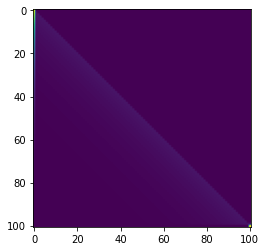

In [32]:
# eqn 12 in Russek 2017

gamma = 0.95

M = np.linalg.inv(np.eye(n_states) - gamma * T_pi)
plt.imshow(M)

Text(0, 0.5, 'State-Values')

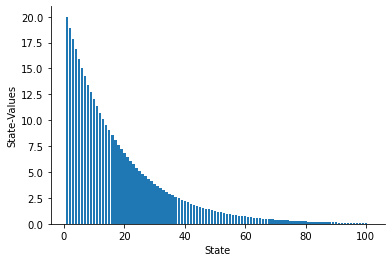

In [56]:
R = np.zeros(n_states)
R[0] = 1
R[-1] = 0

# equation 6, Gershman J Neuro 2018
V = M.dot(R.reshape(-1, 1))
plt.bar(x=np.arange(1, n_states + 1), height=V.reshape(-1))
sns.despine()
# plt.xticks(np.arange(1, n_states + 1))
plt.xlabel('State')
plt.ylabel('State-Values')

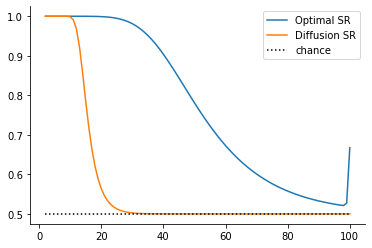

In [62]:
# This model is my own.  One step look-ahead Q-values where
# Q(s, a) = T(s, a, s')V(s')
# with a policy
# pi(s) ~ softmax[Q(s, a)]

beta = 10.

V = M.dot(R.reshape(-1, 1))
Q_left = T_left.dot(V).reshape(-1)
Q_right = T_right.dot(V).reshape(-1)
pi_correct_pre = np.exp(Q_left*beta) / (np.exp(Q_left*beta) + np.exp(Q_right*beta))
plt.plot(np.arange(2, n_states ), pi_correct_pre[1:-1], label='Optimal SR')

# plot the diffusion SR
M_df = np.linalg.inv(np.eye(n_states) - gamma * T_df)
V_df = M_df.dot(R.reshape(-1, 1))
Q_left_df = T_left.dot(V_df).reshape(-1)
Q_right_df = T_right.dot(V_df).reshape(-1)
pi_diff_pre = np.exp(Q_left_df*beta) / (np.exp(Q_left_df*beta) + np.exp(Q_right_df*beta))
plt.plot(np.arange(2, n_states ), pi_diff_pre[1:-1], label='Diffusion SR')

plt.plot(np.arange(2, n_states), np.ones(n_states-2) * 0.5, 'k:', label='chance')

plt.legend()
sns.despine()

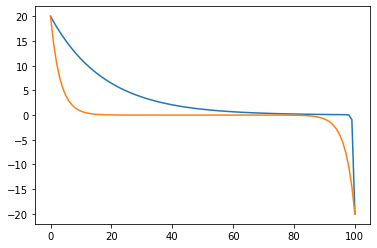

In [55]:
plt.plot(V)
plt.plot(V_df)

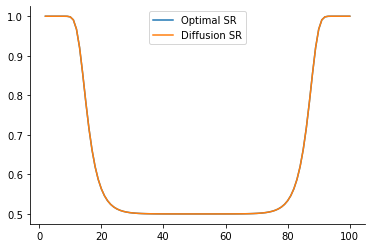

In [51]:
# policy
# pi(s, a) = softmax(Q(s,a))

pi_correct_pre = np.exp(Q_left*beta) / (np.exp(Q_left*beta) + np.exp(Q_right*beta))
plt.plot(np.arange(2, n_states ), pi_correct_pre[1:-1], label='Optimal SR')

# plot the same thing but with the diffusion SR
M_df = np.linalg.inv(np.eye(n_states) - gamma * T_df)
V = M_df.dot(R.reshape(-1, 1))
Q_left = T_left.dot(V).reshape(-1)
Q_right = T_right.dot(V).reshape(-1)
pi_diff_pre = np.exp(Q_left*beta) / (np.exp(Q_left*beta) + np.exp(Q_right*beta))
plt.plot(np.arange(2, n_states ), pi_diff_pre[1:-1], label='Diffusion SR')

plt.legend()
sns.despine()

In [49]:
M_df.shape

(9, 9)

Text(0, 0.5, 'State-Values')

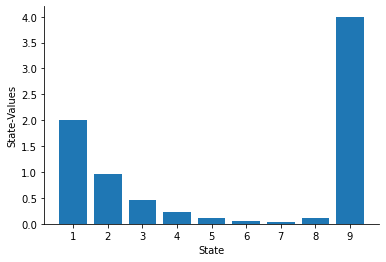

In [9]:

R = np.zeros(9)
R[0] = 1
R[-1] = 2

# equation 6, Gershman J Neuro 2018
V = M.dot(R.reshape(-1, 1))
plt.bar(x=np.arange(1, 10), height=V.reshape(-1))
sns.despine()
plt.xticks(np.arange(1, 10))
plt.xlabel('State')
plt.ylabel('State-Values')

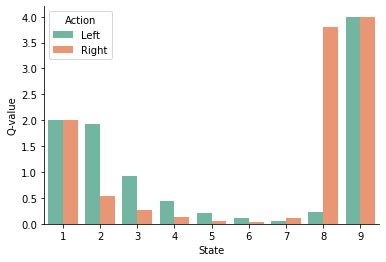

In [10]:
V = M.dot(R.reshape(-1, 1))

# This model is my own.  One step look-ahead Q-values where
# Q(s, a) = T(s, a, s')V(s')

Q_left = T_left.dot(V).reshape(-1)
Q_right = T_right.dot(V).reshape(-1)

df = {
    'State': np.concatenate([np.arange(1, 10), np.arange(1, 10)]),
    'Q-value': np.concatenate([Q_left, Q_right]),
    'Action': ['Left'] * 9 + ['Right'] * 9
}


sns.barplot(x='State',y='Q-value', data=pd.DataFrame(df), hue='Action', palette='Set2')
sns.despine()

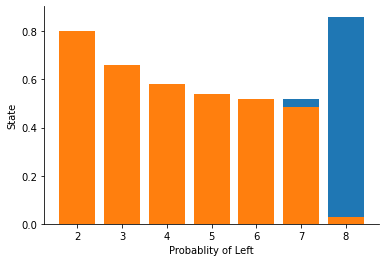

In [11]:
# policy
# pi(s, a) = softmax(Q(s,a))
pi_correct_post = np.exp(Q_left) / (np.exp(Q_left) + np.exp(Q_right))
plt.bar(np.arange(2, 9), pi_correct_pre[1:-1])
plt.bar(np.arange(2, 9), pi_correct_post[1:-1])
plt.xlabel('Probablity of Left')
plt.ylabel('State')
sns.despine()

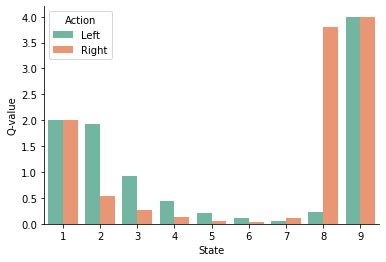

In [12]:
# V = M.dot(R.reshape(-1, 1))
T_left.dot(V)

df = {
    'State': np.concatenate([np.arange(1, 10), np.arange(1, 10)]),
    'Q-value': np.concatenate([T_left.dot(V).reshape(-1), T_right.dot(V).reshape(-1)]),
    'Action': ['Left'] * 9 + ['Right'] * 9
}


sns.barplot(x='State',y='Q-value', data=pd.DataFrame(df), hue='Action', palette='Set2')
sns.despine()

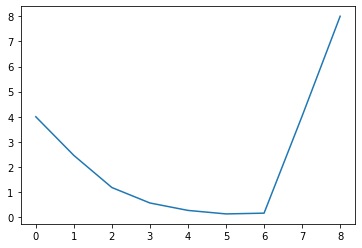

In [13]:
plt.plot((T_right + T_left).dot(V)
)


Text(0.5, 1.0, 'Diffusion policy')

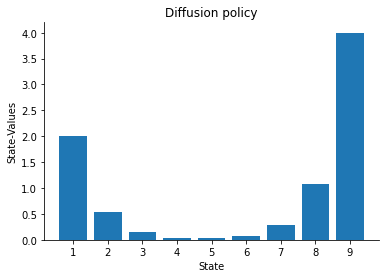

In [14]:
M_df = np.linalg.inv(np.eye(9) - gamma * T_df)
V = M_df.dot(R.reshape(-1, 1))


plt.bar(x=np.arange(1, 10), height=V.reshape(-1))
sns.despine()
plt.xticks(np.arange(1, 10))
plt.xlabel('State')
plt.ylabel('State-Values')
plt.title('Diffusion policy')

In [15]:
state_action_reward_functions = environments.get_state_action_reward_from_sucessor_rewards(
    R, [T_left, T_right]
)

sa_values, s_values = ValueIterationNetwork.value_iteration(
    [T_left, T_right], state_action_reward_functions, n_rows=1, n_columns=n_states, gamma=gamma)
s_values

  0%|          | 0/10 [00:00<?, ?it/s]

array([1.        , 1.44233875, 0.69355008, 0.33756675, 0.32521864,
       0.66690414, 1.38689195, 2.8846723 , 2.        ])

In [16]:
s_values

array([1.        , 1.44233875, 0.69355008, 0.33756675, 0.32521864,
       0.66690414, 1.38689195, 2.8846723 , 2.        ])

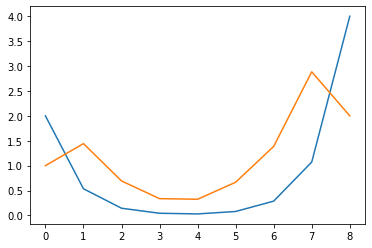

In [17]:
plt.plot(V.reshape(-1))
plt.plot(s_values, )

In [ ]:
sa_values